<a href="https://colab.research.google.com/github/happyendingddd/CRISPR_Cas9_gRNA_design/blob/main/%E2%80%9CCNN_on_target_PR_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [317]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [318]:
# 数据导入1
file_path='/content/hek293t_binary.csv'
data_read=pd.read_csv(file_path,sep=',')
guideSeq=np.array(data_read['sgRNA'])
guideSeq=guideSeq.reshape((guideSeq.shape[0],1))
labels=np.array(data_read['Normalized_efficacy'])
print(guideSeq.shape)

(2333, 1)


In [319]:
def read_gdata(fp,num_read):
  with open(fp, "r") as f:
    list1=[]
    i=0
    for line in f.readlines():
      i+=1
      if i<=num_read:
        line = line.strip('\n')  #去掉列表中每一个元素的换行符
        list1.append(line)
  arr=np.array(list1)
  seq_g=arr.reshape((arr.shape[0],1))
  return seq_g

In [320]:

# after专属代码
# 数据导入2
FP='/content/generated_seq_hek293t_positive.txt'
FN='/content/generated_seq_hek293t_negetive.txt'
num_read=int(guideSeq.shape[0]/2)
seq_gP=read_gdata(FP,num_read)
seq_gN=read_gdata(FN,num_read)
seq_g=np.vstack([seq_gP,seq_gN])
labels_gP=np.zeros(seq_gP.shape[0])+1
labels_gN=np.zeros(seq_gN.shape[0])
labels_g=np.r_[labels_gP,labels_gN]
labels_all=np.r_[labels,labels_g]


In [321]:

# after专属代码
seq_all=np.vstack([guideSeq,seq_g])
print(seq_all.shape)


(4665, 1)


In [322]:
'''
# before专属代码
labels_all=labels
seq_all=guideSeq
'''

'\n# before专属代码\nlabels_all=labels\nseq_all=guideSeq\n'

In [323]:
seq_all=seq_all.reshape(seq_all.shape[0])
print(seq_all.shape)

(4665,)


In [324]:
#one-hot编码
ntmap = {'A': (1, 0, 0, 0),
         'C': (0, 1, 0, 0),
         'G': (0, 0, 1, 0),
         'T': (0, 0, 0, 1)
         }

def get_seqcode(seq):
    return list(map(lambda c: ntmap[c], seq))

def oneHotcoding(Seq):
    n=0
    for seq in Seq:
        if n==0:
            SeqcodeL=[]
        seqcode=get_seqcode(seq)
        n+=1
        SeqcodeL.append(seqcode)
        seqcode=[]
        SeqcodeA=np.array(SeqcodeL)
    return SeqcodeA

In [325]:
guidecode=oneHotcoding(seq_all)

In [326]:
guidecode.shape

(4665, 23, 4)

In [327]:
seqdata_all=guidecode
print(seqdata_all.shape)

(4665, 23, 4)


In [328]:
from sklearn.model_selection import train_test_split
train_seq,test_seq,train_lab,test_lab=train_test_split(seqdata_all,labels_all,train_size = 0.6,random_state=14,stratify=labels_all)

In [329]:
train_seq.shape

(2799, 23, 4)

In [330]:
Ntest_seq=test_seq[:int(test_seq.shape[0]*5/8)]
val_seq=test_seq[int(test_seq.shape[0]*5/8)+1:]
Ntest_lab=test_lab[:int(test_seq.shape[0]*5/8)]
val_lab=test_lab[int(test_seq.shape[0]*5/8)+1:]

In [331]:
def CNN_model():
  model = tf.keras.Sequential()
  
  model.add(layers.Conv1D(16, 3, padding='same', activation='relu', input_shape=(23,4)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv1D(64, 3,padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv1D(64, 3,padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(16, activation='relu'))
  model.add(layers.Dense(2,activation='sigmoid'))

  return model

In [332]:
model=CNN_model()
#model.summary()

In [333]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [334]:
history = model.fit(train_seq, train_lab, epochs=200, batch_size=16,
                    validation_data=(val_seq, val_lab))

Epoch 1/200
175/175 [==============================] - 2s 7ms/step - loss: 0.4457 - accuracy: 0.8077 - val_loss: 0.9865 - val_accuracy: 0.2589
Epoch 2/200
175/175 [==============================] - 1s 6ms/step - loss: 0.1844 - accuracy: 0.9429 - val_loss: 0.6770 - val_accuracy: 0.6209
Epoch 3/200
175/175 [==============================] - 1s 6ms/step - loss: 0.1406 - accuracy: 0.9516 - val_loss: 0.2652 - val_accuracy: 0.9041
Epoch 4/200
175/175 [==============================] - 1s 6ms/step - loss: 0.1276 - accuracy: 0.9597 - val_loss: 0.2149 - val_accuracy: 0.9227
Epoch 5/200
175/175 [==============================] - 1s 6ms/step - loss: 0.1097 - accuracy: 0.9703 - val_loss: 0.1989 - val_accuracy: 0.9385
Epoch 6/200
175/175 [==============================] - 1s 6ms/step - loss: 0.1021 - accuracy: 0.9671 - val_loss: 0.1580 - val_accuracy: 0.9442
Epoch 7/200
175/175 [==============================] - 1s 6ms/step - loss: 0.0821 - accuracy: 0.9685 - val_loss: 0.1590 - val_accuracy: 0.9428

In [335]:
test_loss, test_acc = model.evaluate(Ntest_seq, Ntest_lab, verbose=2)

37/37 - 0s - loss: 0.3353 - accuracy: 0.9786


In [336]:
print(test_acc)

0.9785591959953308


In [337]:
pred_pro=model.predict(Ntest_seq) #计算概率
pred_pro.shape

(1166, 2)

In [338]:
# PR曲线（精确率/召回率）
from sklearn.metrics import precision_recall_curve,auc
precision, recall, thresholds=precision_recall_curve(Ntest_lab,pred_pro[:,1]) # 计算多种阈值的p,r
pr_auc = auc(recall, precision)
print(pr_auc)

0.974576409972249


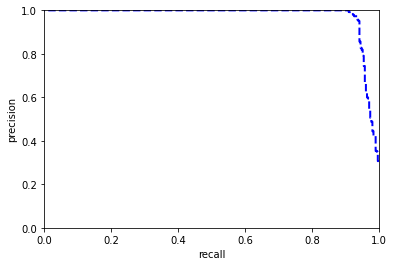

In [339]:
# PR曲线
def plot_pr_curve(recall,precision,label=None):
    plt.plot(recall,precision,'b--',linewidth=2,label=label)
    plt.axis([0,1,0,1])
    plt.xlabel('recall')
    plt.ylabel('precision')
plot_pr_curve(recall,precision)
plt.show()

In [340]:
listnew=[list(recall),list(precision)]

In [341]:
#def savedata2D(list1,filepath,test_acc,AUC):
def savedata2D(list1,filepath):
    output = open(filepath,'w+',encoding='utf-8')
    for i in range(len(list1)):
        for j in range(len(list1[i])):
                output.write(str(list1[i][j]))    
                output.write('\t')   
        output.write('\n')
    #output.write(AUC)
    #output.write('\n')
    #output.write(str(test_acc))
    #output.write('\n')
    output.close()

In [342]:
#fp_roc='/content/data_ROC_on_after.txt'
fp_pr='/content/data_PR_on_after.txt'
#savedata2D(listnew,fp,test_acc,AUC)
#savedata2D(listnew,fp_roc)
savedata2D(listnew,fp_pr)

In [343]:
'''
fp1='/content/data_ROC_on_after.txt'
fp2='/content/data_ROC_on_before.txt'
listA=np.loadtxt(fp1)
listB=np.loadtxt(fp2)
'''

"\nfp1='/content/data_ROC_on_after.txt'\nfp2='/content/data_ROC_on_before.txt'\nlistA=np.loadtxt(fp1)\nlistB=np.loadtxt(fp2)\n"

In [344]:
'''
# 绘制前后变化
def plot_roc_curve2(fpr1,tpr1,fpr2,tpr2,label1,label2,title):
    plt.plot(fpr1,tpr1,'r--',linewidth=2,label=label1)
    plt.plot(fpr2,tpr2,'g--',linewidth=2,label=label2)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('Fales Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.legend(loc='upper right')
    plt.title(title)
    '''

"\n# 绘制前后变化\ndef plot_roc_curve2(fpr1,tpr1,fpr2,tpr2,label1,label2,title):\n    plt.plot(fpr1,tpr1,'r--',linewidth=2,label=label1)\n    plt.plot(fpr2,tpr2,'g--',linewidth=2,label=label2)\n    plt.plot([0,1],[0,1],'k--')\n    plt.axis([0,1,0,1])\n    plt.xlabel('Fales Positive Rate')\n    plt.ylabel('True Positive Rate')\n\n    plt.legend(loc='upper right')\n    plt.title(title)\n    "

In [345]:
'''
plot_roc_curve2(listB[0],listB[1],listA[0],listA[1],'before','after',None)
plt.show()
'''

"\nplot_roc_curve2(listB[0],listB[1],listA[0],listA[1],'before','after',None)\nplt.show()\n"

In [346]:
# 保存模型
#model.save('/content/model_trained.h5') 


In [347]:
# 加载模型，同时加载了模型的结构、权重等信息
#loaded_model = tf.keras.models.load_model('/content/model_trained.h5')